In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import os
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py
import tables
import pandas as pd

In [3]:
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=16)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=16)    # legend fontsize
matplotlib.rc('figure', titlesize=16)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rc('figure.subplot', hspace=  0.4)
fs = 1/2e-9
def process_data(trace, recordlength):
    try:
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    except ValueError:
        trace = trace[:int(np.floor(len(trace)/recordlength))*recordlength,]
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    data= traceR-np.expand_dims(traceR[:,100:2000].mean(axis=1), axis=1)
#     print ('input trace length',trace.shape, 'processed trace shape',  data.shape)
    return data
def create_template(traces):
    template = np.mean(traces, axis = 0)
    template_norm= -template/min(template)
    return template,template_norm

def clippedwaveformsindex(data, clippingstart = -15100):
    clippedIdx = []
    data_max_idx = np.argmin(data, axis=1) 
    for i in range(len(data)):
        if data[i][data_max_idx[i]] < clippingstart:
            clippedIdx.append(i)
    return clippedIdx


def glitchesindex(data, threshold = 5):
    glitchesIdx = []
    
    std = ((data[:, 100:1000].std(axis=1)).reshape(len(data),1))
    t0idx = np.argmax(data<-(10*std), axis=1)   
        
    data_max_idx = np.argmin(data, axis=1)
    
    for i in range(len(data)):
        if data_max_idx[i] - t0idx[i] < threshold:
            glitchesIdx.append(i)
    return glitchesIdx


def pileupindex(data, ctype):
    pileupIdx, noisyIdx = [], []

    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    
    if ctype == 'pure': distancefactor, prominencefactor = 15,  0.085
    else: distancefactor, prominencefactor = 200, 0.4
    if ctype == 'pure': threshold_min, threshold_max = 15,40
    else: threshold_min, threshold_max = 350,900
        
    data_max_idx = np.argmin(data, axis=1)
    data_max = data[np.arange(len(data_max_idx)),data_max_idx]  
    for i in range(0, len(data)):
        peaks, peak_properties = find_peaks(-data[i], prominence =(-data_max[i]*prominencefactor), distance=distancefactor)
        if len(peaks)>1 :
            pileupIdx.append(i)
        if energy[i] > threshold_max or energy[i] < threshold_min:
            noisyIdx.append(i)
    return pileupIdx, noisyIdx

def OF_calct0(signal, template_norm, psd_noise, fs, recordlength):
    amp, t0, chi2= [], [], []
    for trace in np.arange(len(signal)):
        OF = qp.OptimumFilter(signal[trace], template_norm, psd_noise, fs) # initialize the OptimumFilter class
        amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
        amp.append(amp_withdelay)
        t0.append(t0_withdelay)
        chi2.append(chi2_withdelay)
    return amp, t0, chi2
templateEM_Tl,  TemplateEM_Tl = create_template(np.load('templates/Tl_template_pulses.npy'))
templateHAD_Tl,  TemplateHAD_Tl = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))

templateEM_p,  TemplateEM_p = create_template(np.load('templates/pure_template_pulses.npy'))
templateHAD_p,  TemplateHAD_p = create_template(np.load('templates/pure_template_pulses_neutron.npy'))

fs =1/2e-9

 
# energy in [ADC] / energyfactor = energy in [MeV]
'''energyfactor_pure 6243
energyfactor_Tl 118252

longtime_pure 250
shorttime_pure 24

longtime_Tl 11000
shorttime_Tl 600'''
def Ecalibration (amp, ctype):
    if ctype == 'Tl':
        return amp/118252
    if ctype == 'pure':
        return amp/6243

In [169]:
len_all_identifiers = 1159
len_identifiers_15min_beamOFF = 89
len_identifiers_15min_beamON = 1046
len_identifiers_2hours_beamOFF = 6
len_identifiers_2hours_beamON =18
len_all_identifiers_cosmics = 20

# CsI Pure

7163151
gli, clip, pileup, noisy 130467 768025 1002724 640108
4968557


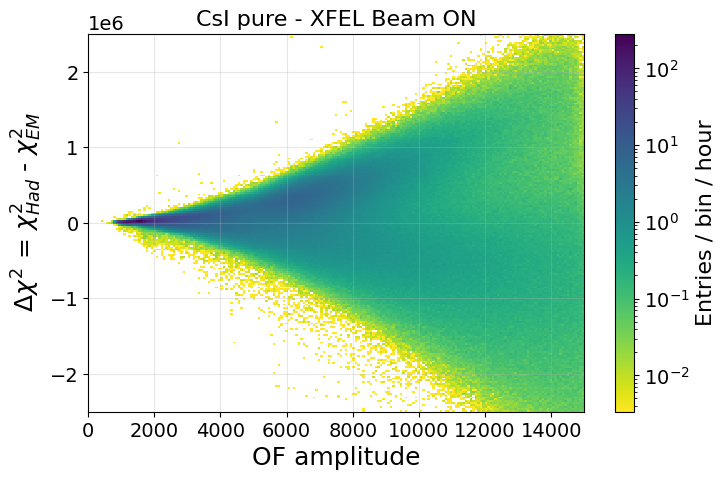

peak memory: 3976.62 MiB, increment: 147.21 MiB


In [160]:
%%memit
XFEL_ON_p = h5py.File('saved_outputs/pure_XFEL_beamON.hdf5')

print (len(XFEL_ON_p ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_ON_p['glitch'][:]==True)[0]
clip= np.where(XFEL_ON_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_ON_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_ON_p['noisypulse'][:]==True)[0]
pileup_excess= np.where(XFEL_ON_p['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))
print('gli, clip, pileup, noisy', len(gli), len(clip), len(pileup), len(noisy))
# select = [0]

XFEL_ON_p_amp = np.delete(XFEL_ON_p ['amp_withdelay_EM'][:],select)
XFEL_ON_p_chi2 = np.delete(XFEL_ON_p ['chi2_withdelay_EM'][:],select)
XFEL_ON_p_sav_EM=np.delete(XFEL_ON_p ['chi2_sav_EM'][:],select)
XFEL_ON_p_t0pil = np.delete(XFEL_ON_p['t0_pileup_EM'][:],select)
XFEL_ON_p_amppil = np.delete(XFEL_ON_p['amp_pileup_EM'][:],select)
XFEL_ON_p_data_min =np.delete(XFEL_ON_p['data_amp_min'][:],select)
XFEL_ON_p_fit_min =np.delete(XFEL_ON_p['fit_amp_min_EM'][:],select)
XFEL_ON_p_int_amp =np.delete(XFEL_ON_p['integrated_raw_amp'][:],select)
XFEL_ON_p_rundata = np.delete(XFEL_ON_p['rundata'][:],select)
XFEL_ON_p_waveform_number = np.delete(XFEL_ON_p['waveform_number'][:],select)

XFEL_ON_p_amp_Had = np.delete(np.array(XFEL_ON_p ['amp_withdelay_Had']), select)
XFEL_ON_p_chi2_Had = np.delete(np.array(XFEL_ON_p ['chi2_withdelay_Had']), select)
XFEL_ON_p_sav_Had=np.delete(np.array(XFEL_ON_p ['chi2_sav_Had']), select)
integrated_raw_amp_p_XFEL = np.delete(np.array(XFEL_ON_p ['integrated_raw_amp']), select)

XFEL_ON_p_deltachi2=np.delete(np.array(XFEL_ON_p ['Delta_chi2']), select)
print (len(XFEL_ON_p_amp))


# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_ON_p_amp, XFEL_ON_p_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - XFEL Beam ON - EM template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_ON_p_amp, XFEL_ON_p_chi2/15000,bins=(200,np.logspace(-1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - XFEL Beam ON - EM template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/2chi_p_XFEL_BeamON_EMtemplate.png',bbox_inches = 'tight')
# plt.show()




# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_ON_p_amp_Had, XFEL_ON_p_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - XFEL Beam ON - Hadron template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_ON_p_amp_Had, XFEL_ON_p_chi2_Had/15000,bins=(200,np.logspace(-1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - XFEL Beam ON - Hadron template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/2chi_p_XFEL_BeamON_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()


# plt.figure(figsize=(8, 5))

# plt.hist2d(XFEL_ON_p_amp, XFEL_ON_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid(alpha=0.3)
# plt.title('CsI pure - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_OFamp_.png',bbox_inches = 'tight')
# plt.show()

plt.figure(figsize=(8, 5))
w = np.ones_like(XFEL_ON_p_deltachi2)/(len_identifiers_15min_beamON*0.25 +  len_identifiers_2hours_beamON*2  )
plt.hist2d(XFEL_ON_p_amp, XFEL_ON_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),weights=w, cmap='viridis_r', norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries / bin / hour')
plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_OFamp_hour.png',bbox_inches = 'tight')
plt.show()


# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(XFEL_ON_p_int_amp, 'pure'), XFEL_ON_p_deltachi2,bins=(np.linspace(0,90,200),np.linspace(-0.25e7, 0.25e7, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,80)
# plt.grid(alpha=0.3)
# plt.title('CsI pure - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
# plt.show()


In [133]:
len(XFEL_ON_p_deltachi2)

4968557

In [10]:
len(XFEL_ON_p_amp)*30e-6/60/60

0.04140464166666667

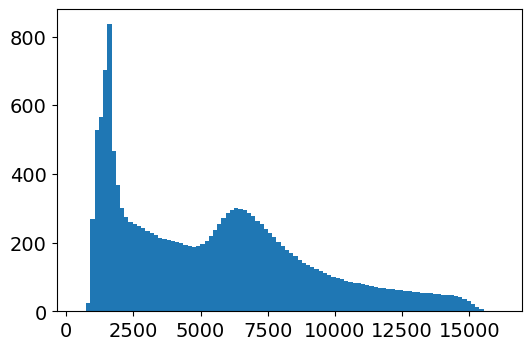

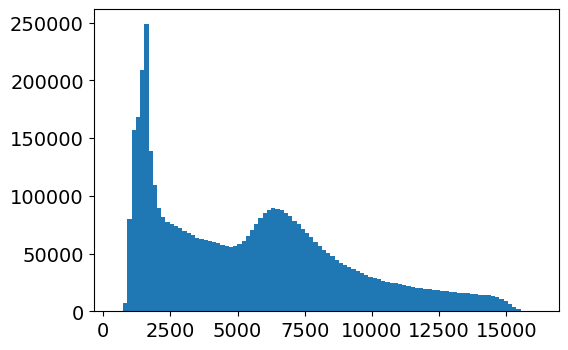

In [138]:
weights = np.ones_like(XFEL_ON_p_amp)/len(XFEL_ON_p_amp)
weights = len(XFEL_ON_p_amp)*[1 / (len_identifiers_15min_beamON*0.25 +  len_identifiers_2hours_beamON*2  )]
# print((weights), XFEL_ON_p_amp)
plt.hist(XFEL_ON_p_amp, bins =100, weights = weights)
plt.show()
plt.hist(XFEL_ON_p_amp, bins =100)
plt.show()

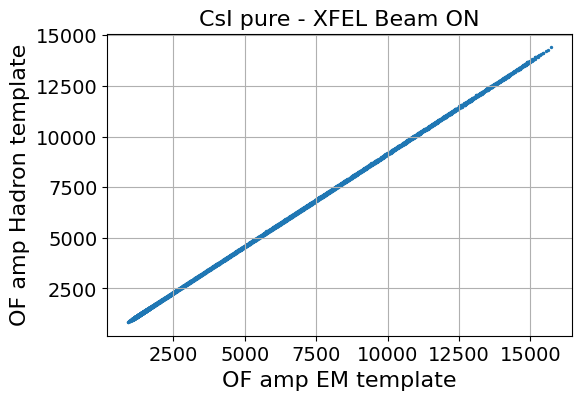

In [5]:
plt.scatter(XFEL_ON_p_amp[:10000], XFEL_ON_p_amp_Had[:10000], s =2)
plt.grid()
plt.title('CsI pure - XFEL Beam ON')
plt.xlabel('OF amp EM template')
plt.ylabel('OF amp Hadron template')
plt.show()

In [1]:
15000*2e-9 

3e-05

In [5]:
15000*2e-9*1e6

30.0

In [6]:
30e-6/15000

2e-09

In [6]:
for n in np.arange(0,15000,3000):
    print((n , n+3000))
    plt.figure(figsize=(8, 5))
    if n==0: ybins = np.linspace(-0.03e7, 0.03e7, 200)
    elif n==3000: ybins = np.linspace(-0.1e7, 0.1e7, 200)
    elif n==6000: ybins = np.linspace(-0.2e7, 0.2e7, 200)
    elif n==9000: ybins = np.linspace(-0.25e7, 0.25e7, 200)
    else: ybins = np.linspace(-0.4e7, 0.4e7, 200)
    if n==0: xbins = np.linspace(700 , n+3000,800)
    else: xbins = np.linspace(n , n+3000,800)
    plt.hist2d(XFEL_ON_p_amp, XFEL_ON_p_deltachi2,bins=(xbins,ybins), cmin=1, norm=LogNorm())
    plt.xlabel(r'OF amplitude',fontsize=18)
    plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
#     plt.xlim(n , n+3000)
    plt.grid(alpha=0.3)
    plt.title('CsI pure - XFEL Beam ON')
    cbar = plt.colorbar()
    cbar.set_label('Entries/bin')
    plt.savefig('../../../plots/beamON/bands/pure_%s.png'%(str(n)+'-'+str(n+3000)),bbox_inches = 'tight')
    plt.show()
np.save("../saved_outputs/beamON_delchi", XFEL_p_amp)

(0, 3000)


NameError: name 'XFEL_p_amp' is not defined

<Figure size 800x500 with 0 Axes>

In [5]:

CR_p_XFEL = np.delete(np.array(XFEL_ON_p ['charge_ratio']), select)
plt.figure(figsize=(8, 5))
plt.hist2d(Ecalibration(XFEL_ON_p_int_amp, 'pure'), CR_p_XFEL,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'Energy [MeV]',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
plt.xlim(0,80)
plt.grid()
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()


7163151


NameError: name 'XFEL_ON_p_int_amp' is not defined

<Figure size 800x500 with 0 Axes>

7163151


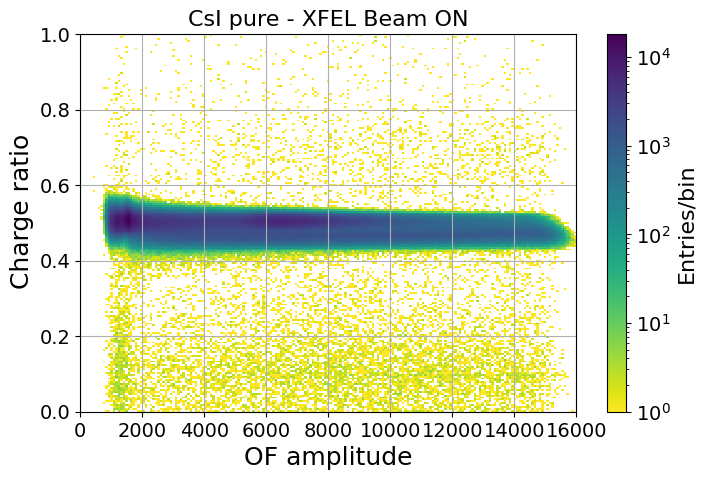

In [9]:
XFEL_ON_p = h5py.File('saved_outputs/pure_XFEL_beamON.hdf5')

print (len(XFEL_ON_p ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_ON_p['glitch'][:]==True)[0]
clip= np.where(XFEL_ON_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_ON_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_ON_p['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
XFEL_ON_p_amp = np.delete(XFEL_ON_p ['amp_withdelay_EM'][:],select)

CR_p_XFEL = np.delete(np.array(XFEL_ON_p ['charge_ratio']), select)
plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_ON_p_amp, CR_p_XFEL,bins=(np.linspace(0,16000,200), np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
# plt.xlim(0,80)
plt.grid()
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()


In [ ]:



slices=np.arange(1000,14000,1000)
for s in slices:
    sl = [i for i, x in enumerate(XFEL_ON_p_amp) if x>s and x<s+1000]
    print(s, len(sl))
    if s  < 4000: bins = np.linspace(-0.5e6,0.5e6,100)
    elif s  < 7000: bins = np.linspace(-1e6,1e6,100)
    elif s  < 11000: bins = np.linspace(-2e6,2e6,100)
    else: bins = np.linspace(-3e6,3e6,100)
    plt.hist(np.take(XFEL_ON_p_deltachi2,sl), bins =bins, histtype = 'step', linewidth =2)
    plt.title('CsI pure - beam ON - OF amp:'+str(s)+'-'+str(s+1000))
    plt.xlabel(r'$\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$')
    plt.ylabel('a.u')
    plt.grid()
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.savefig('../../../plots/beamON/bands/pure_%s.png'%(str(s)+'-'+str(s+1000)),bbox_inches = 'tight')
    plt.show()

254737
gli, clip, pileup, noisy 3538 6431 4939 4600
238638


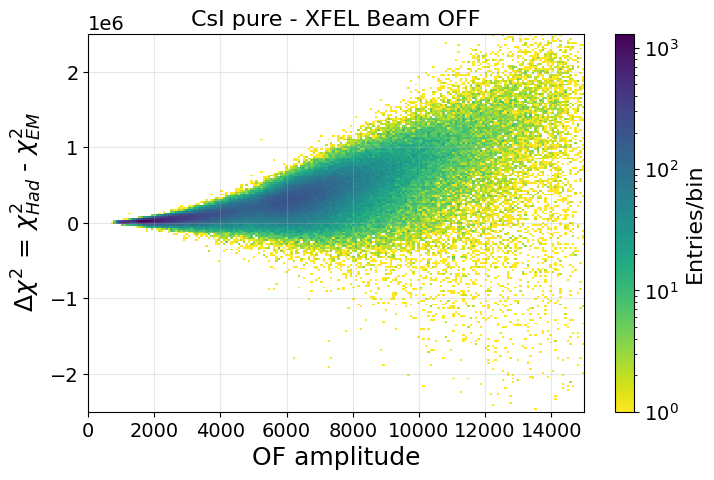

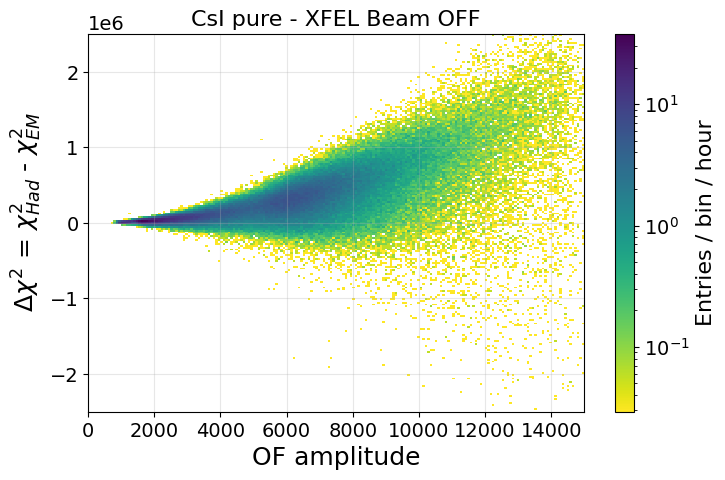

In [168]:

XFEL_OFF_p = h5py.File('saved_outputs/pure_XFEL_beamOFF.hdf5')

print (len(XFEL_OFF_p ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_OFF_p['glitch'][:]==True)[0]
clip= np.where(XFEL_OFF_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_OFF_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_OFF_p['noisypulse'][:]==True)[0]
pileup_excess= np.where(XFEL_OFF_p['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))
print('gli, clip, pileup, noisy', len(gli), len(clip), len(pileup), len(noisy))
# select = [0]

XFEL_OFF_p_amp = np.delete(XFEL_OFF_p ['amp_withdelay_EM'][:],select)
XFEL_OFF_p_chi2 = np.delete(XFEL_OFF_p ['chi2_withdelay_EM'][:],select)
XFEL_OFF_p_sav_EM=np.delete(XFEL_OFF_p ['chi2_sav_EM'][:],select)
XFEL_OFF_p_t0pil = np.delete(XFEL_OFF_p['t0_pileup_EM'][:],select)
XFEL_OFF_p_amppil = np.delete(XFEL_OFF_p['amp_pileup_EM'][:],select)
XFEL_OFF_p_data_min =np.delete(XFEL_OFF_p['data_amp_min'][:],select)
XFEL_OFF_p_fit_min =np.delete(XFEL_OFF_p['fit_amp_min_EM'][:],select)
XFEL_OFF_p_int_amp =np.delete(XFEL_OFF_p['integrated_raw_amp'][:],select)
XFEL_OFF_p_rundata = np.delete(XFEL_OFF_p['rundata'][:],select)
XFEL_OFF_p_waveform_number = np.delete(XFEL_OFF_p['waveform_number'][:],select)

XFEL_OFF_p_amp_Had = np.delete(np.array(XFEL_OFF_p ['amp_withdelay_Had']), select)
XFEL_OFF_p_chi2_Had = np.delete(np.array(XFEL_OFF_p ['chi2_withdelay_Had']), select)
XFEL_OFF_p_sav_Had=np.delete(np.array(XFEL_OFF_p ['chi2_sav_Had']), select)
integrated_raw_amp_p_XFEL = np.delete(np.array(XFEL_OFF_p ['integrated_raw_amp']), select)

XFEL_OFF_p_deltachi2=np.delete(np.array(XFEL_OFF_p ['Delta_chi2']), select)
print (len(XFEL_OFF_p_amp))


# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_OFF_p_amp, XFEL_OFF_p_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - XFEL Beam OFF - EM template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_OFF_p_amp, XFEL_OFF_p_chi2/15000,bins=(200,np.logspace(-1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - XFEL Beam OFF - EM template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamOFF/2chi_p_XFEL_BeamOFF_EMtemplate.png',bbox_inches = 'tight')
# plt.show()




# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_OFF_p_amp_Had, XFEL_OFF_p_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - XFEL Beam OFF - Hadron template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_OFF_p_amp_Had, XFEL_OFF_p_chi2_Had/15000,bins=(200,np.logspace(-1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - XFEL Beam OFF - Hadron template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamOFF/2chi_p_XFEL_BeamOFF_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()


plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_OFF_p_amp, XFEL_OFF_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam OFF')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.savefig('../../../plots/beamOFF/DeltaChi2_p_XFEL_BeamOFF_OFamp_.png',bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(8, 5))
w = np.ones_like(XFEL_OFF_p_amp)/(len_identifiers_15min_beamOFF*0.25 +  len_identifiers_2hours_beamOFF*2  )
plt.hist2d(XFEL_OFF_p_amp, XFEL_OFF_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),cmap='viridis_r', weights=w, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam OFF')
cbar = plt.colorbar()
cbar.set_label('Entries / bin / hour')
plt.savefig('../../../plots/beamOFF/DeltaChi2_p_XFEL_BeamOFF_OFamp_hour.png',bbox_inches = 'tight')
plt.show()

# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(XFEL_OFF_p_int_amp, 'pure'), XFEL_OFF_p_deltachi2,bins=(np.linspace(0,80,200),np.linspace(-0.25e7, 0.25e7, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,80)
# plt.grid(alpha=0.3)
# plt.title('CsI pure - XFEL Beam OFF')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamOFF/DeltaChi2_p_XFEL_BeamOFF_Energy.png',bbox_inches = 'tight')
# plt.show()


696320
673479


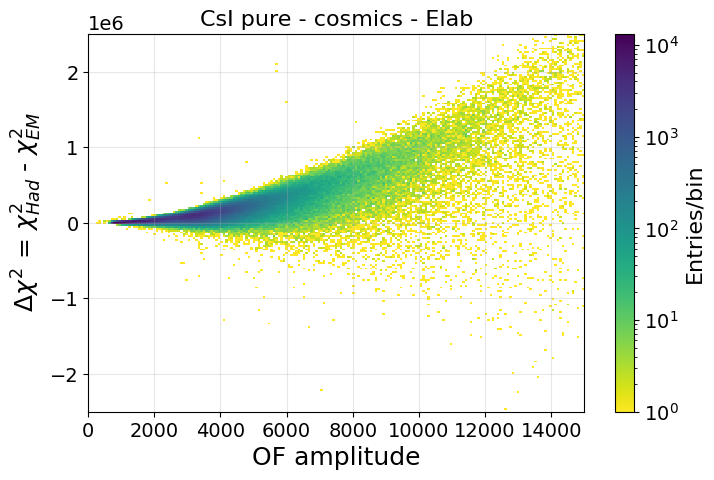

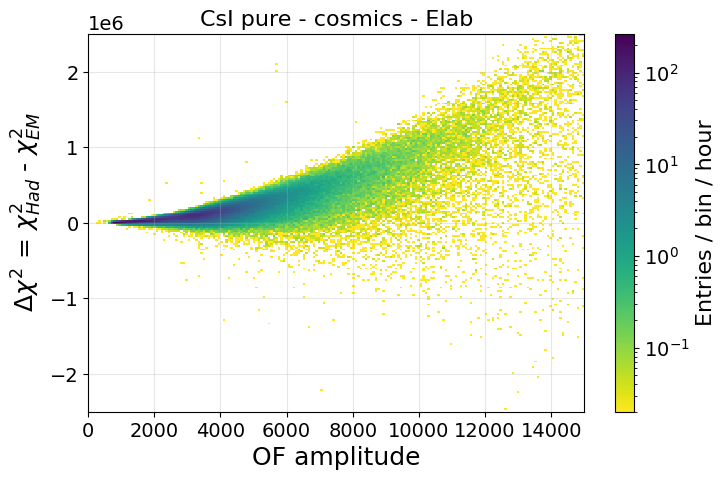

In [170]:

cosmics_p = h5py.File('saved_outputs/pure_cosmics_Elab.hdf5')


print(len(cosmics_p ['amp_withdelay_EM'][:]))

gli= np.where(cosmics_p['glitch'][:]==True)[0]
clip= np.where(cosmics_p['clipped'][:]==True)[0]
pileup= np.where(cosmics_p['pileup'][:]==True)[0]
noisy= np.where(cosmics_p['noisypulse'][:]==True)[0]
pileup_excess= np.where(cosmics_p['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))
# select = []

cosmics_p_amp = np.delete(cosmics_p ['amp_withdelay_EM'][:],select)
cosmics_p_chi2 = np.delete(cosmics_p ['chi2_withdelay_EM'][:],select)
cosmics_p_sav_EM=np.delete(cosmics_p ['chi2_sav_EM'][:],select)
cosmics_p_t0pil = np.delete(cosmics_p['t0_pileup_EM'][:],select)
cosmics_p_amppil = np.delete(cosmics_p['amp_pileup_EM'][:],select)
cosmics_p_data_min =np.delete(cosmics_p['data_amp_min'][:],select)
cosmics_p_fit_min =np.delete(cosmics_p['fit_amp_min_EM'][:],select)
cosmics_p_int_amp =np.delete(cosmics_p['integrated_raw_amp'][:],select)
cosmics_p_rundata = np.delete(cosmics_p['rundata'][:],select)
cosmics_p_waveform_number = np.delete(cosmics_p['waveform_number'][:],select)

cosmics_p_amp_Had = np.delete(np.array(cosmics_p ['amp_withdelay_Had']), select)
cosmics_p_chi2_Had = np.delete(np.array(cosmics_p ['chi2_withdelay_Had']), select)
cosmics_p_sav_Had=np.delete(np.array(cosmics_p ['chi2_sav_Had']), select)
integrated_raw_amp_p_cosmics = np.delete(np.array(cosmics_p ['integrated_raw_amp']), select)

cosmics_p_deltachi2=np.delete(np.array(cosmics_p ['Delta_chi2']), select)
print (len(cosmics_p_amp))


# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(cosmics_p_amp, cosmics_p_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - cosmics - Elab - EM template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(cosmics_p_amp, cosmics_p_chi2/15000,bins=(200,np.logspace(-1,7, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - cosmics - Elab - EM template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/2chi_p_XFEL_cosmicsElab_EMtemplate.png',bbox_inches = 'tight')
# plt.show()




# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(cosmics_p_amp_Had, cosmics_p_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI pure - cosmics - Elab - Hadron template')
# plt.ylim(0,20.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(cosmics_p_amp_Had, cosmics_p_chi2_Had/15000,bins=(200,np.logspace(-1,7, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI pure - cosmics - Elab - Hadron template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/2chi_p_XFEL_cosmicsElab_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()



plt.figure(figsize=(8, 5))
plt.hist2d(cosmics_p_amp, cosmics_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - cosmics - Elab')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.savefig('../../../plots/cosmicsElab/DeltaChi2_p_cosmicsElab_OFamp_.png',bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(8, 5))
w = np.ones_like(cosmics_p_amp)/(len_all_identifiers_cosmics*2.5 )
plt.hist2d(cosmics_p_amp, cosmics_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)),cmap='viridis_r', weights = w, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - cosmics - Elab')
cbar = plt.colorbar()
cbar.set_label('Entries / bin / hour')
plt.savefig('../../../plots/cosmicsElab/DeltaChi2_p_cosmicsElab_OFamp_hour.png',bbox_inches = 'tight')
plt.show()

# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(cosmics_p_int_amp, 'pure'), cosmics_p_deltachi2,bins=(np.linspace(0,80,200),np.linspace(-0.25e7, 0.25e7, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# # plt.xlim(0,1e-3)
# plt.grid(alpha=0.3)
# # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.title('CsI pure - cosmics - Elab')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/DeltaChi2_p_cosmicsElab_Energy.png',bbox_inches = 'tight')
# plt.show()



In [ ]:
bins = np.linspace(0,0.6e6,200)
# bins = 500
plt.hist(XFEL_p_int_amp[:len(cosmics_p_int_amp)], histtype= 'step',linewidth = 2, bins =bins, label = 'XFEL beam on')
plt.hist(cosmics_p_int_amp, histtype= 'step',linewidth = 2, bins =bins, label = 'Elab cosmics')
plt.title ('CsI pure, with pre-selection')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.grid()
plt.legend()

# CsI Tl

6522407
4860493


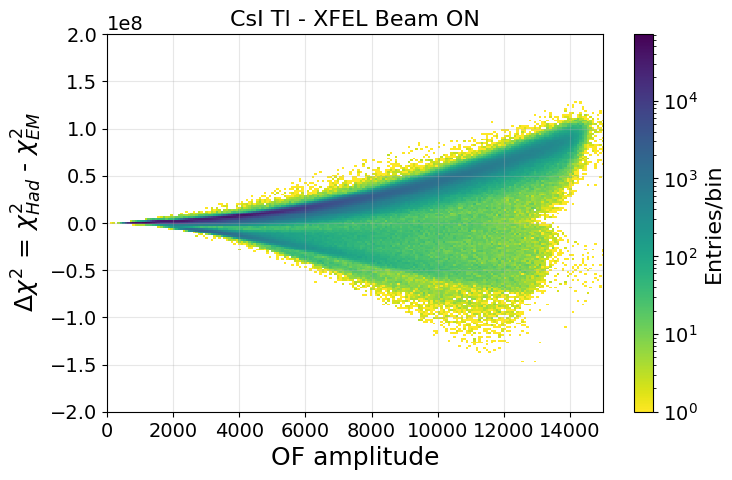

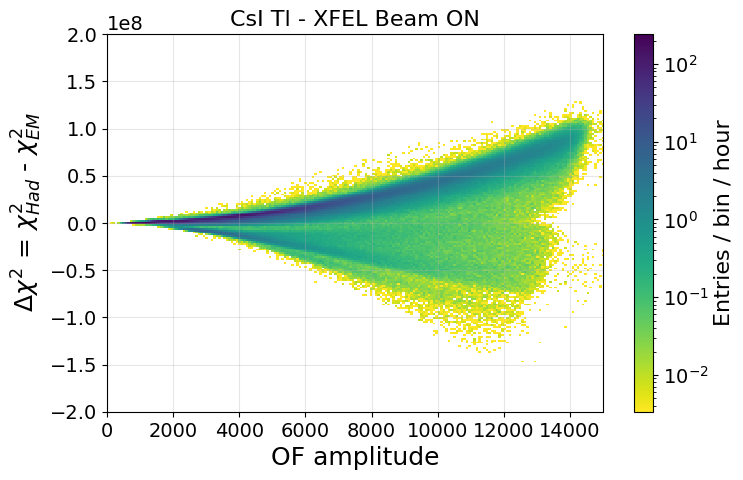

In [171]:

XFEL_Tl = h5py.File('saved_outputs/Tl_XFEL_beamON.hdf5')

print(len(XFEL_Tl ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_Tl['noisypulse'][:]==True)[0]
pileup_excess= np.where(XFEL_Tl['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))
# select = []



XFEL_Tl_amp = np.delete(XFEL_Tl ['amp_withdelay_EM'][:],select)
XFEL_Tl_chi2 = np.delete(XFEL_Tl ['chi2_withdelay_EM'][:],select)
XFEL_Tl_sav_EM=np.delete(XFEL_Tl ['chi2_sav_EM'][:],select)
XFEL_Tl_t0pil = np.delete(XFEL_Tl['t0_pileup_EM'][:],select)
XFEL_Tl_amppil = np.delete(XFEL_Tl['amp_pileup_EM'][:],select)
XFEL_Tl_data_min =np.delete(XFEL_Tl['data_amp_min'][:],select)
XFEL_Tl_fit_min =np.delete(XFEL_Tl['fit_amp_min_EM'][:],select)
XFEL_Tl_int_amp =np.delete(XFEL_Tl['integrated_raw_amp'][:],select)
XFEL_Tl_rundata = np.delete(XFEL_Tl['rundata'][:],select)
XFEL_Tl_waveform_number = np.delete(XFEL_Tl['waveform_number'][:],select)

XFEL_Tl_amp_Had = np.delete(np.array(XFEL_Tl ['amp_withdelay_Had']), select)
XFEL_Tl_chi2_Had = np.delete(np.array(XFEL_Tl ['chi2_withdelay_Had']), select)
XFEL_Tl_sav_Had=np.delete(np.array(XFEL_Tl ['chi2_sav_Had']), select)
integrated_raw_amp_Tl_XFEL = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)

XFEL_Tl_deltachi2=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
print (len(XFEL_Tl_amp))






# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_Tl_amp, XFEL_Tl_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - XFEL Beam ON - EM template')
# plt.ylim(0,200.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')

# plt.subplot(2,2,2)
# plt.hist2d(XFEL_Tl_amp, XFEL_Tl_chi2/15000,bins=(200,np.logspace(0,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - XFEL Beam ON - EM template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/2chi_Tl_XFEL_BeamON_EMtemplate.png',bbox_inches = 'tight')
# plt.show()



# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_Tl_amp_Had, XFEL_Tl_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - XFEL Beam ON - Hadron template')
# plt.ylim(0,200.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_Tl_amp_Had, XFEL_Tl_chi2_Had/15000,bins=(200,np.logspace(0,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - XFEL Beam ON - Hadron template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/2chi_Tl_XFEL_BeamON_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()

plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.savefig('../../../plots/beamON/DeltaChi2_Tl_XFEL_BeamON_OFamp_.png',bbox_inches = 'tight')

plt.show()

plt.figure(figsize=(8, 5))
w = np.ones_like(XFEL_Tl_amp)/(len_identifiers_15min_beamON*0.25 +  len_identifiers_2hours_beamON*2  )
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', weights=w, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries / bin / hour')
plt.savefig('../../../plots/beamON/DeltaChi2_Tl_XFEL_BeamON_OFamp_hour.png',bbox_inches = 'tight')
plt.show()

# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(XFEL_Tl_int_amp, 'Tl'), XFEL_Tl_deltachi2,bins=(np.linspace(0,90,200),np.linspace(-0.2e9, 0.2e9, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_Tl_XFEL_BeamON_Energy.png',bbox_inches = 'tight')

# plt.show()


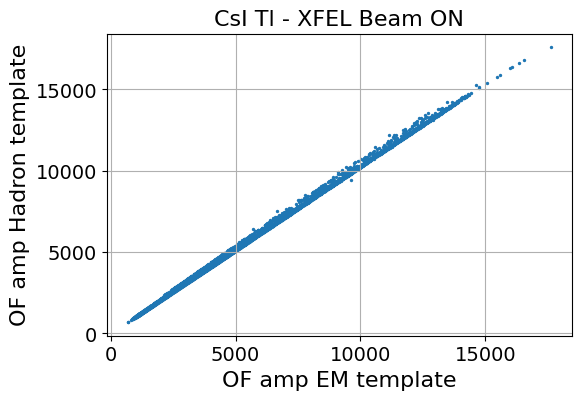

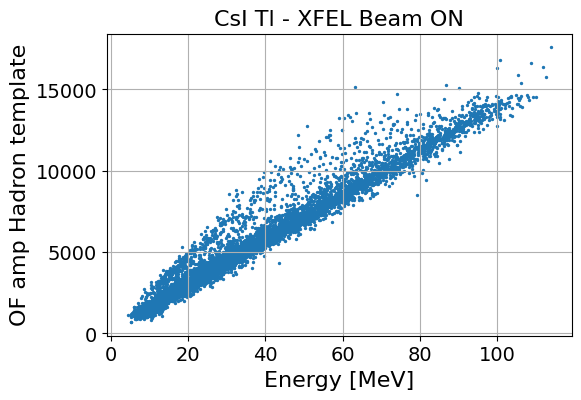

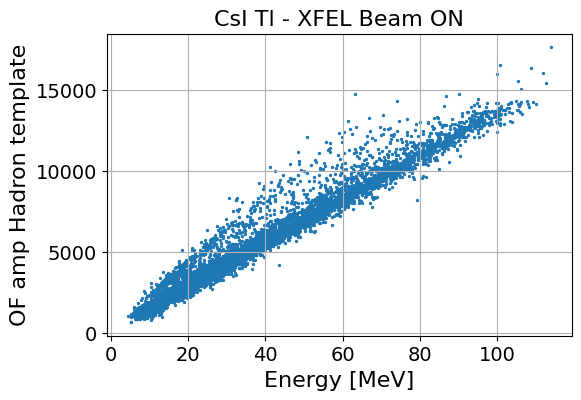

In [12]:
plt.scatter(XFEL_Tl_amp[:10000], XFEL_Tl_amp_Had[:10000], s =2)
plt.grid()
plt.title('CsI Tl - XFEL Beam ON')
plt.xlabel('OF amp EM template')
plt.ylabel('OF amp Hadron template')
plt.show()


plt.scatter(Ecalibration(XFEL_Tl_int_amp, 'Tl')[:10000], XFEL_Tl_amp_Had[:10000], s =2)
plt.grid()
plt.title('CsI Tl - XFEL Beam ON')
plt.xlabel('Energy [MeV]')
plt.ylabel('OF amp Hadron template')
plt.show()

plt.scatter(Ecalibration(XFEL_Tl_int_amp, 'Tl')[:10000], XFEL_Tl_amp[:10000], s =2)
plt.grid()
plt.title('CsI Tl - XFEL Beam ON')
plt.xlabel('Energy [MeV]')
plt.ylabel('OF amp Hadron template')
plt.show()


In [ ]:

slices=np.arange(1000,14000,1000)
for s in slices:
    sl = [i for i, x in enumerate(XFEL_Tl_amp) if x>s and x<s+1000]
    print(s, len(sl))
    bins = np.linspace(-1e8,1e8,100)
    if s  < 4000: bins = np.linspace(-0.1e8,0.1e8,100)
    elif s  < 9000: bins = np.linspace(-0.6e8,0.6e8,100)
    else: bins = np.linspace(-1e8,1e8,100)
    plt.hist(np.take(XFEL_Tl_deltachi2,sl), bins =bins,  histtype = 'step', linewidth = 2)
    plt.title('CsI Tl - beam ON - OF amp:'+str(s)+'-'+str(s+1000))
    plt.xlabel(r'$\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel('a.u')
    plt.yscale('log')
    plt.grid()
    plt.savefig('../../../plots/beamON/bands/Tl_%s.png'%(str(n)+'-'+str(n+3000)),bbox_inches = 'tight')
    plt.show()

In [ ]:

CR_Tl_XFEL = np.delete(np.array(XFEL_Tl ['charge_ratio']), select)

plt.figure(figsize=(8, 5))
plt.hist2d(Ecalibration(XFEL_Tl_int_amp, 'Tl'), CR_Tl_XFEL,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'Energy [MeV]',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
plt.xlim(0,90)
plt.grid()
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()


251291
233520


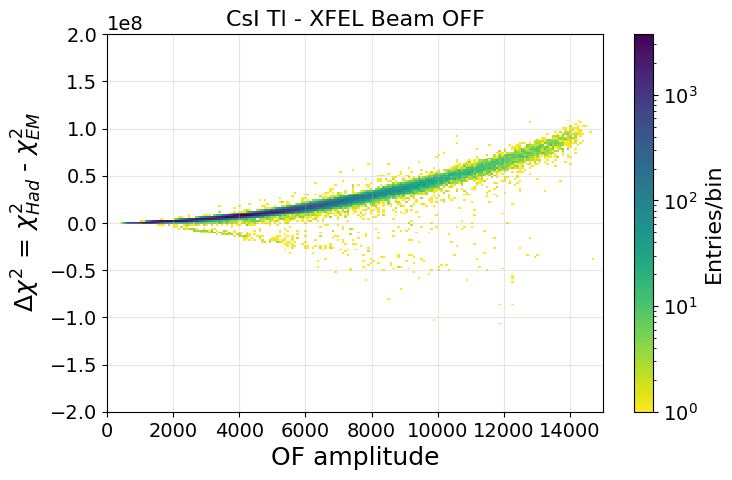

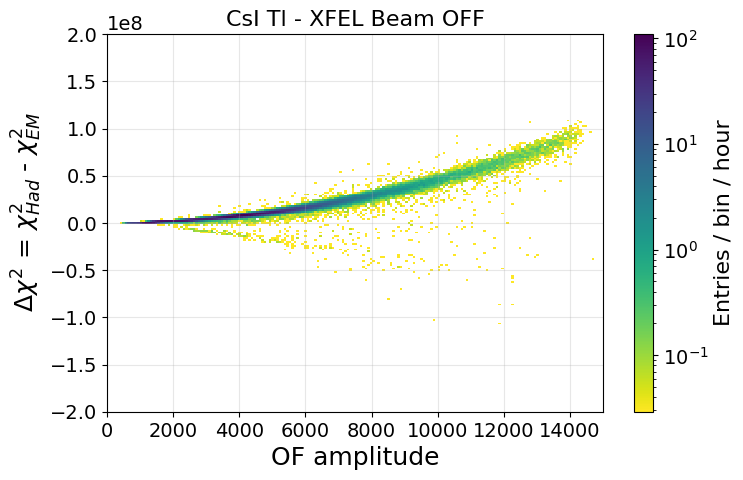

In [174]:

XFEL_OFF_Tl = h5py.File('saved_outputs/Tl_XFEL_beamOFF.hdf5')

print(len(XFEL_OFF_Tl ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_OFF_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_OFF_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_OFF_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_OFF_Tl['noisypulse'][:]==True)[0]
pileup_excess= np.where(XFEL_OFF_Tl['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))



XFEL_OFF_Tl_amp = np.delete(XFEL_OFF_Tl ['amp_withdelay_EM'][:],select)
XFEL_OFF_Tl_chi2 = np.delete(XFEL_OFF_Tl ['chi2_withdelay_EM'][:],select)
XFEL_OFF_Tl_sav_EM=np.delete(XFEL_OFF_Tl ['chi2_sav_EM'][:],select)
XFEL_OFF_Tl_t0pil = np.delete(XFEL_OFF_Tl['t0_pileup_EM'][:],select)
XFEL_OFF_Tl_amppil = np.delete(XFEL_OFF_Tl['amp_pileup_EM'][:],select)
XFEL_OFF_Tl_data_min =np.delete(XFEL_OFF_Tl['data_amp_min'][:],select)
XFEL_OFF_Tl_fit_min =np.delete(XFEL_OFF_Tl['fit_amp_min_EM'][:],select)
XFEL_OFF_Tl_int_amp =np.delete(XFEL_OFF_Tl['integrated_raw_amp'][:],select)
XFEL_OFF_Tl_rundata = np.delete(XFEL_OFF_Tl['rundata'][:],select)
XFEL_OFF_Tl_waveform_number = np.delete(XFEL_OFF_Tl['waveform_number'][:],select)

XFEL_OFF_Tl_amp_Had = np.delete(np.array(XFEL_OFF_Tl ['amp_withdelay_Had']), select)
XFEL_OFF_Tl_chi2_Had = np.delete(np.array(XFEL_OFF_Tl ['chi2_withdelay_Had']), select)
XFEL_OFF_Tl_sav_Had=np.delete(np.array(XFEL_OFF_Tl ['chi2_sav_Had']), select)
integrated_raw_amp_Tl_XFEL = np.delete(np.array(XFEL_OFF_Tl ['integrated_raw_amp']), select)

XFEL_OFF_Tl_deltachi2=np.delete(np.array(XFEL_OFF_Tl ['Delta_chi2']), select)
print (len(XFEL_OFF_Tl_amp))






# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_OFF_Tl_amp, XFEL_OFF_Tl_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - XFEL Beam OFF - EM template')
# plt.ylim(0,200.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = cbar = plt.colorbar(); cbar.set_label('Entries/bin');
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_OFF_Tl_amp, XFEL_OFF_Tl_chi2/15000,bins=(200,np.logspace(0,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - XFEL Beam OFF - EM template')
# cbar = plt.colorbar(); cbar.set_label('Entries/bin');
# plt.savefig('../../../plots/beamOFF/2chi_Tl_XFEL_BeamOFF_EMtemplate.png',bbox_inches = 'tight')
# plt.show()




# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(XFEL_OFF_Tl_amp_Had, XFEL_OFF_Tl_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - XFEL Beam OFF - Hadron template')
# plt.ylim(0,200.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar(); cbar.set_label('Entries/bin');
# plt.subplot(2,2,2)
# plt.hist2d(XFEL_OFF_Tl_amp_Had, XFEL_OFF_Tl_chi2_Had/15000,bins=(200,np.logspace(0,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - XFEL Beam OFF - Hadron template')
# cbar = plt.colorbar(); cbar.set_label('Entries/bin');
# plt.savefig('../../../plots/beamOFF/2chi_Tl_XFEL_BeamOFF_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()


plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_OFF_Tl_amp, XFEL_OFF_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam OFF')
cbar = plt.colorbar(); cbar.set_label('Entries/bin');
plt.savefig('../../../plots/beamOFF/DeltaChi2_Tl_XFEL_BeamOFF_OFamp_.png',bbox_inches = 'tight')
plt.show()
plt.figure(figsize=(8, 5))
w = np.ones_like(XFEL_OFF_Tl_amp)/(len_identifiers_15min_beamOFF*0.25 +  len_identifiers_2hours_beamOFF*2  )
plt.hist2d(XFEL_OFF_Tl_amp, XFEL_OFF_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', weights = w, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam OFF')
cbar = plt.colorbar(); cbar.set_label('Entries / bin / hour');
plt.savefig('../../../plots/beamOFF/DeltaChi2_Tl_XFEL_BeamOFF_OFamp_hour.png',bbox_inches = 'tight')
plt.show()

# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(XFEL_OFF_Tl_int_amp, 'Tl'), XFEL_OFF_Tl_deltachi2,bins=(np.linspace(0,90,200),np.linspace(-0.2e9, 0.2e9, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - XFEL Beam OFF')
# cbar = plt.colorbar(); cbar.set_label('Entries/bin');
# plt.savefig('../../../plots/beamOFF/DeltaChi2_Tl_XFEL_BeamOFF_Energy.png',bbox_inches = 'tight')

# plt.show()


590836
573380


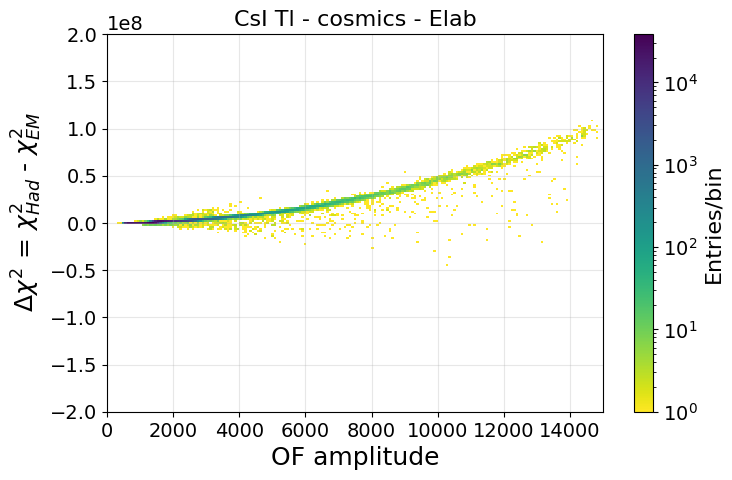

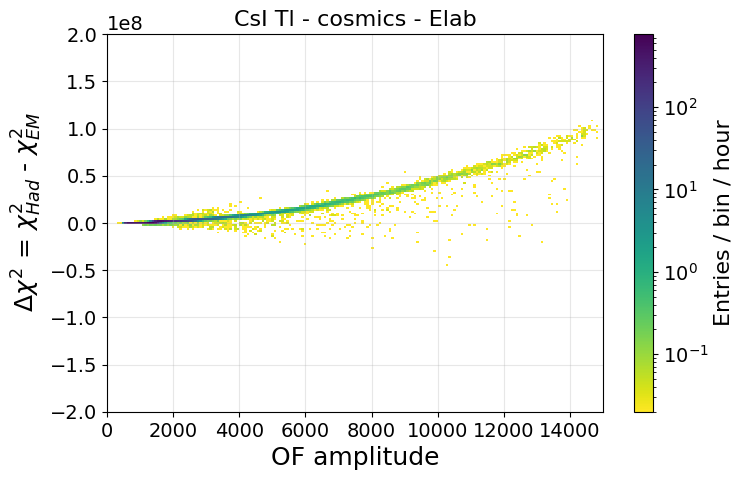

In [177]:

cosmics_Tl = h5py.File('saved_outputs/Tl_cosmics_Elab.hdf5')

print (len(cosmics_Tl['amp_withdelay_EM'][:]))
gli= np.where(cosmics_Tl['glitch'][:]==True)[0]
clip= np.where(cosmics_Tl['clipped'][:]==True)[0]
pileup= np.where(cosmics_Tl['pileup'][:]==True)[0]
noisy= np.where(cosmics_Tl['noisypulse'][:]==True)[0]
pileup_excess= np.where(cosmics_Tl['pileup_excess'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy, pileup_excess),0))
# select = []


cosmics_Tl_amp = np.delete(cosmics_Tl ['amp_withdelay_EM'][:],select)
cosmics_Tl_chi2 = np.delete(cosmics_Tl ['chi2_withdelay_EM'][:],select)
cosmics_Tl_sav_EM=np.delete(cosmics_Tl ['chi2_sav_EM'][:],select)
cosmics_Tl_t0pil = np.delete(cosmics_Tl['t0_pileup_EM'][:],select)
cosmics_Tl_amppil = np.delete(cosmics_Tl['amp_pileup_EM'][:],select)
cosmics_Tl_data_min =np.delete(cosmics_Tl['data_amp_min'][:],select)
cosmics_Tl_fit_min =np.delete(cosmics_Tl['fit_amp_min_EM'][:],select)
cosmics_Tl_int_amp =np.delete(cosmics_Tl['integrated_raw_amp'][:],select)
cosmics_Tl_rundata = np.delete(cosmics_Tl['rundata'][:],select)
cosmics_Tl_waveform_number = np.delete(cosmics_Tl['waveform_number'][:],select)

cosmics_Tl_amp_Had = np.delete(np.array(cosmics_Tl ['amp_withdelay_Had']), select)
cosmics_Tl_chi2_Had = np.delete(np.array(cosmics_Tl ['chi2_withdelay_Had']), select)
cosmics_Tl_sav_Had=np.delete(np.array(cosmics_Tl ['chi2_sav_Had']), select)
integrated_raw_amp_Tl_cosmics = np.delete(np.array(cosmics_Tl ['integrated_raw_amp']), select)

cosmics_Tl_deltachi2=np.delete(np.array(cosmics_Tl ['Delta_chi2']), select)
print (len(cosmics_Tl_amp))


# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(cosmics_Tl_amp, cosmics_Tl_sav_EM,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - cosmics - Elab - EM template')
# plt.ylim(0,50.)
# plt.xlim(0,15000)
# plt.grid()
# plt.colorbar()
# plt.subplot(2,2,2)
# plt.hist2d(cosmics_Tl_amp, cosmics_Tl_chi2/15000,bins=(200,np.logspace(1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - cosmics - Elab - EM template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/2chi_Tl_XFEL_cosmicsElab_EMtemplate.png',bbox_inches = 'tight')
# plt.show()








# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
# plt.hist2d(cosmics_Tl_amp_Had, cosmics_Tl_sav_Had,bins=(500,1500), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
# plt.title('CsI Tl - cosmics - Elab - Hadron template')
# plt.ylim(0,50.)
# plt.xlim(0,15000)
# plt.grid()
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.subplot(2,2,2)
# plt.hist2d(cosmics_Tl_amp_Had, cosmics_Tl_chi2_Had/15000,bins=(200,np.logspace(1,6, 100)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid()
# plt.yscale('log')
# plt.title('CsI Tl - cosmics - Elab - Hadron template')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/2chi_Tl_XFEL_cosmicsElab_Hadtemplate.png',bbox_inches = 'tight')
# plt.show()


plt.figure(figsize=(8, 5))
plt.hist2d(cosmics_Tl_amp, cosmics_Tl_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - cosmics - Elab')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.savefig('../../../plots/cosmicsElab/DeltaChi2_Tl_cosmicsElab_OFamp_.png',bbox_inches = 'tight')

plt.show()
plt.figure(figsize=(8, 5))
w = np.ones_like(cosmics_Tl_amp)/(len_all_identifiers_cosmics*2.5 )
plt.hist2d(cosmics_Tl_amp, cosmics_Tl_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.2e9, 0.2e9, 200)),cmap='viridis_r', weights = w, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - cosmics - Elab')
cbar = plt.colorbar()
cbar.set_label('Entries / bin / hour')
plt.savefig('../../../plots/cosmicsElab/DeltaChi2_Tl_cosmicsElab_OFamp_hour.png',bbox_inches = 'tight')

plt.show()


# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(cosmics_Tl_int_amp, 'Tl'), cosmics_Tl_deltachi2,bins=(np.linspace(0,90,200),np.linspace(-0.2e9, 0.2e9, 150)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# # plt.xlim(0,1e-3)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - cosmics - Elab')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/cosmicsElab/DeltaChi2_Tl_cosmicsElab_Energy.png',bbox_inches = 'tight')

# plt.show()

In [ ]:
plt.hist(XFEL_Tl_int_amp, histtype= 'step', linewidth = 3, bins =400, label = 'XFEL beam on')
plt.hist(cosmics_Tl_int_amp, histtype= 'step', linewidth = 3, bins =400, label = 'Elab cosmics')
plt.grid()
plt.xlim(-0.05e8,0.2e8)
plt.legend()

In [ ]:

XFEL_p = h5py.File('saved_outputs/pure_template_pulses_neutron.hdf5')
XFEL_p_amp = XFEL_p ['amp_withdelay_EM'][:]
XFEL_p_chi2 = XFEL_p ['chi2_withdelay_EM'][:]
XFEL_p_sav_EM=XFEL_p ['chi2_sav_EM'][:]
XFEL_p_t0pil = XFEL_p['t0_pileup_EM'][:]
XFEL_p_amppil = XFEL_p['amp_pileup_EM'][:]
XFEL_p_data_min =XFEL_p['data_amp_min'][:]
XFEL_p_fit_min =XFEL_p['fit_amp_min_EM'][:]
print (len(XFEL_p_amp))





plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
plt.hist2d(XFEL_p_amp, XFEL_p_sav_EM,bins=(10,50), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
plt.title('CsI pure - neutron enriched - EM template')
plt.ylim(0,20.)
plt.xlim(0,16000)
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()
# plt.show()
plt.subplot(2,2,2)
plt.hist2d(XFEL_p_amp, XFEL_p_chi2/16000,bins=(10,np.logspace(-1,6, 50)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.ylim(1,15)
plt.xlim(0,16000)
# plt.xlim(0,1e-3)
plt.grid()
plt.yscale('log')
plt.title('CsI pure - neutron enriched - EM template')
plt.colorbar()
plt.show()

select =[]
XFEL_p_amp = np.delete(np.array(XFEL_p ['amp_withdelay_Had']), select)
XFEL_p_chi2 = np.delete(np.array(XFEL_p ['chi2_withdelay_Had'])/16000, select)
XFEL_p_sav_Had=np.delete(np.array(XFEL_p ['chi2_sav_Had']), select)
integrated_raw_amp_p_XFEL = np.delete(np.array(XFEL_p ['integrated_raw_amp']), select)

XFEL_p_deltachi2=np.delete(np.array(XFEL_p ['Delta_chi2']), select)
print (len(XFEL_p_amp))




plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
plt.hist2d(XFEL_p_amp, XFEL_p_sav_Had,bins=(10,50), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
plt.title('CsI pure - neutron enriched - Hadron template')
plt.ylim(0,20.)
plt.xlim(0,16000)
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()
# plt.show()
plt.subplot(2,2,2)
plt.hist2d(XFEL_p_amp, XFEL_p_chi2,bins=(10,np.logspace(-1,6, 50)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.ylim(1,15)
plt.xlim(0,16000)
plt.grid()
plt.yscale('log')
plt.title('CsI pure - neutron enriched - Hadron template')
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_p_amp, XFEL_p_deltachi2,bins=(10,np.linspace(-1e7, 1e7, 50)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.ylim(1,15)
plt.xlim(0,16000)
# plt.xlim(0,1e-3)
plt.grid()
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.yscale('log')
plt.title('CsI pure - neutron enriched')
plt.colorbar()
plt.show()



In [ ]:

XFEL_Tl = h5py.File('saved_outputs/Tl_template_pulses_neutron.hdf5')
XFEL_Tl_amp = XFEL_Tl ['amp_withdelay_EM'][:]
XFEL_Tl_chi2 = XFEL_Tl ['chi2_withdelay_EM'][:]
XFEL_Tl_sav_EM=XFEL_Tl ['chi2_sav_EM'][:]
XFEL_Tl_t0pil = XFEL_Tl['t0_pileup_EM'][:]
XFEL_Tl_amppil = XFEL_Tl['amp_pileup_EM'][:]
XFEL_Tl_data_min =XFEL_Tl['data_amp_min'][:]
XFEL_Tl_fit_min =XFEL_Tl['fit_amp_min_EM'][:]
print (len(XFEL_Tl_amp))




XFEL_p = h5py.File('saved_outputs/pure_template_pulses_neutron.hdf5')
XFEL_p_amp = XFEL_p ['amp_withdelay_EM'][:]
XFEL_p_chi2 = XFEL_p ['chi2_withdelay_EM'][:]
XFEL_p_sav_EM=XFEL_p ['chi2_sav_EM'][:]
XFEL_p_t0pil = XFEL_p['t0_pileup_EM'][:]
XFEL_p_amppil = XFEL_p['amp_pileup_EM'][:]
XFEL_p_data_min =XFEL_p['data_amp_min'][:]
XFEL_p_fit_min =XFEL_p['fit_amp_min_EM'][:]
print (len(XFEL_p_amp))



plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_sav_EM,bins=(10,50), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
plt.title('CsI Tl - neutron enriched - EM template')
plt.ylim(0,50.)
plt.xlim(0,16000)
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()
# plt.show()
plt.subplot(2,2,2)
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_chi2/16000,bins=(10,np.logspace(-1,6, 50)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.ylim(1,15)
plt.xlim(0,16000)
# plt.xlim(0,1e-3)
plt.grid()
plt.yscale('log')
plt.title('CsI Tl - neutron enriched - EM template')
plt.colorbar()
plt.show()

select =[]
XFEL_Tl_amp = np.delete(np.array(XFEL_Tl ['amp_withdelay_Had']), select)
XFEL_Tl_chi2 = np.delete(np.array(XFEL_Tl ['chi2_withdelay_Had'])/16000, select)
XFEL_Tl_sav_Had=np.delete(np.array(XFEL_Tl ['chi2_sav_Had']), select)
integrated_raw_amp_Tl_XFEL = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)

XFEL_Tl_deltachi2=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
print (len(XFEL_Tl_amp))




plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_sav_Had,bins=(10,50), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r' $ |data-fit|$ ',fontsize=18)
plt.title('CsI Tl - neutron enriched - Hadron template')
plt.ylim(0,50.)
plt.xlim(0,16000)
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()
# plt.show()
plt.subplot(2,2,2)
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_chi2,bins=(10,np.logspace(-1,6, 50)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'  OF $\chi^2$',fontsize=18)
# plt.ylim(1,15)
plt.xlim(0,16000)
plt.grid()
plt.yscale('log')
plt.title('CsI Tl - neutron enriched - Hadron template')
plt.colorbar()
plt.show()






plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,16000)
# plt.xlim(0,1e-3)
plt.grid()
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.yscale('log')
plt.title('CsI pure - neutron enriched')
plt.colorbar()
plt.show()
